## PageRank

This is a translation of the [PageRank function](https://github.com/GraphBLAS/LAGraph/blob/master/Source/Algorithm/LAGraph_pagerank3a.c) for the GAP Benchmark work done by Dr. Tim Davis at TAMU.

"PageRank works by counting the number and quality of links to a page to determine a rough estimate of how important the website is. The underlying assumption is that more important websites are likely to receive more links from other websites." - <https://en.wikipedia.org/wiki/PageRank>

(11, 11)


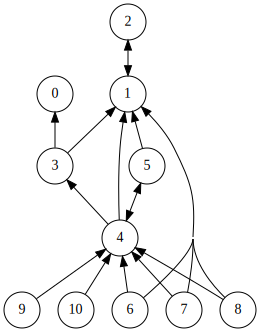

In [1]:
from operator import methodcaller
from pygraphblas import *
from pygraphblas.gviz import *

I = [1,2,3,4,5,3,4,4,5,6,6,7,7,8,8,9,10]
J = [2,1,1,1,1,0,3,5,4,1,4,1,4,1,4,4,4]
V = 1.0
M = Matrix.from_lists(I, J, V, 11, 11, typ=FP32)

print(M.shape)
draw(M, show_weight=False, rankdir='BT')

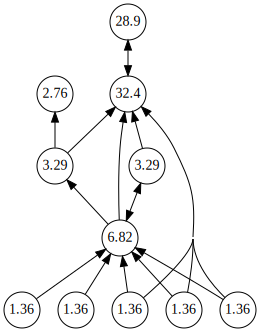

In [2]:
from pygraphblas import *
from pygraphblas.gviz import draw


def pagerank(A, d, damping, itermax):
    n = A.nrows
    r = Vector.sparse(FP32, n)
    t = Vector.sparse(FP32, n)
    d.assign_scalar(damping, accum=FP32.div)
    r[:] = 1.0 / n
    teleport = (1 - damping) / n
    tol = 1e-4
    rdiff = 1.0
    for iters in range(itermax):
        # swap t and r
        temp = t ; t = r ; r = temp
        w = t / d
        r[:] = teleport
        A.plus_second(w,
              out=r,
              accum=FP32.plus,
              desc=descriptor.T0)
        t -= r
        t.abs(out=t)
        rdiff = t.reduce_float()
        if rdiff <= tol:
            break
    return r, iters

# GAP passes the out degree
d = M.reduce_vector(FP32.plus_monoid)
pr, iters = pagerank(M, d, 0.85, 100)

draw(M, label_vector=pr*100, show_weight=False, label_width=4, rankdir='BT')

# Wikipedia Reference

![](https://upload.wikimedia.org/wikipedia/en/8/8b/PageRanks-Example.jpg)

In [3]:
from pathlib import Path
c = Path('~/.ssgetpy')
wikipedia = dict(Matrix.ssget('Gleich/wikipedia-20070206', binary_cache_dir=c))
W = wikipedia['wikipedia-20070206.mtx']

In [5]:
W = W.cast(FP32)
d = W.reduce_vector(FP32.plus_monoid)
pr, iters = pagerank(W, d, 0.85, 100)

In [9]:
pr.reduce_float(FP32.max_monoid)

0.002556494902819395